In [1]:
import numpy as np
import matplotlib.pyplot as plt
import myokit
import matplotlib.colors as clrs
import matplotlib.cm as cm

In [3]:
# Load the model predictions

# Initialise the outputs variable
map_2D = np.zeros((101, 101))

# Load all the simulation outputs
for ical in range(101):
    loaded = np.loadtxt('Simulated QNet/ical_rescale_' + str(float(ical)/100) + '.csv')
    map_2D[100-ical, :] = loaded

# Flip the map so that map_2D[i,j] contains QNet for i% of ICaL block and j% of IKr block
map_2D = np.fliplr(map_2D)


In [4]:
print(np.min(map_2D))
print(np.max(map_2D))

-0.10620845280935028
0.10865968974830964


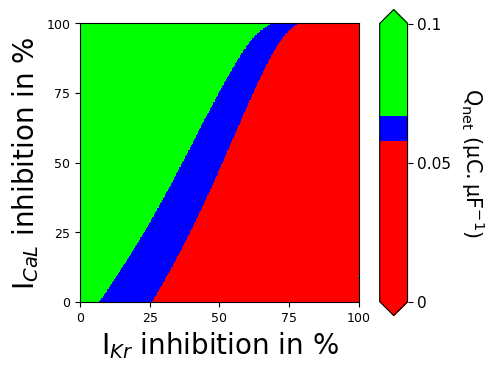

In [5]:
# Plot the 2D map
fig, axes = plt.subplots(1, 2, figsize = (5, 4), gridspec_kw = {'width_ratios':[1, 0.1]})

ax = axes[0]
# Label axes
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_yticks([0, 25, 50, 75, 100])
ax.tick_params(labelsize = 9)
ax.set_xlabel('I$_{Kr}$ inhibition in %', fontsize = 20)
ax.set_ylabel('I$_{CaL}$ inhibition in %', fontsize = 20)

# Adjust the colormap
cmax = 0.1
cmin = 0
n_points = 256
viridis = cm.get_cmap('viridis', n_points)
newcolors = viridis(np.linspace(0, 1, n_points))
# Low risk category in green above 0.0671
index_low = int((0.0671 - cmin) / (cmax-cmin) * n_points) 
newcolors[index_low:] = [0, 1, 0, 1]
# Mid risk category in blue between 0.0581 and 0.0671
index_mid = int((0.0581 - cmin) / (cmax-cmin) * n_points) 
newcolors[index_mid:index_low] = [0, 0, 1, 1]
# High risk category in red below 0.0581
newcolors[:index_mid] = [1, 0, 0, 1] 
newcmp = clrs.ListedColormap(newcolors)

# Plot
image=ax.imshow(map_2D, cmap = newcmp, vmin = cmin, vmax = cmax, origin='lower')

# Add the legend
ax=axes[1]
#legend = ax.imshow(np.zeros((400, 1)), cmap = newcmp, vmin = cmin, vmax = cmax)
cbar = fig.colorbar(image, cax = ax, shrink = 1, extend = 'both')
cbar.set_ticks([0, 0.05, 0.1])
cbar.ax.set_yticklabels([0, 0.05, 0.1], fontsize = 11)
cbar.set_label('$\mathregular{Q_{net}}$ $\mathregular{(\mu C.\mu F^{-1})}$', rotation=270, fontsize = 15, labelpad = 25)
#ax.text(x = 2.5, y = 75, ha = 'center', va = 'center', s = '$\mathregular{\Delta APD_{90}}$ (ms)', rotation=270, fontsize = 15)

# Tight layout and save
plt.tight_layout()
plt.savefig('2-D map of Qnet.png', dpi = 300)
plt.savefig('2-D map of Qnet.pdf', format = 'pdf', transparent=True)


# Test QNet is computed correctly

In [6]:
import myokit
# Load the model
m, p, _ = myokit.load('../MMT models/ORd_CiPA.mmt')

# Set 0.5 Hz pacing
protocol = myokit.Protocol()
protocol.schedule(1, 0, 0.5, 2000, 0)
s = myokit.Simulation(m, protocol)

# Set tolerance
s.set_tolerance(1e-10, 1e-10)

# Save initial state
default_state = s.state()


In [7]:
# Set the drug effect
s.set_constant('drug.ikr_rescale', 1)
s.set_constant('drug.ical_rescale', 1)

# Pre-run for 1000 pre-paces at 0.5 Hz
s.reset()
s.set_state(default_state)
s.pre(2000000)

# Output every 0.01 ms
out = s.run(1990, log_interval = 0.01)
AP = np.array(out['membrane.V'])
IKr = np.array(out['IKr.IKr'])
ICaL = np.array(out['ICaL.ICaL'])
INaL = np.array(out['INaL.INaL'])
IKs = np.array(out['IKs.IKs'])
IK1 = np.array(out['IK1.IK1'])
Ito = np.array(out['Ito.Ito'])

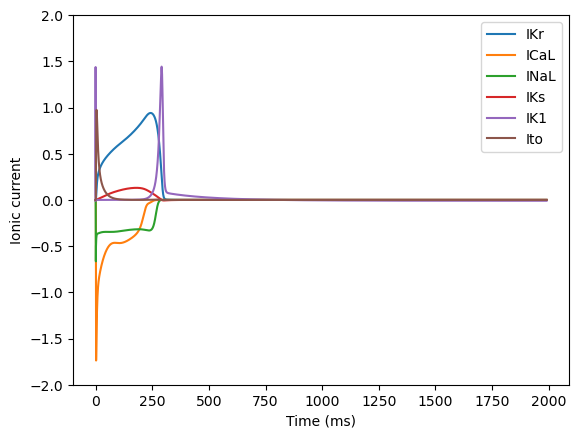

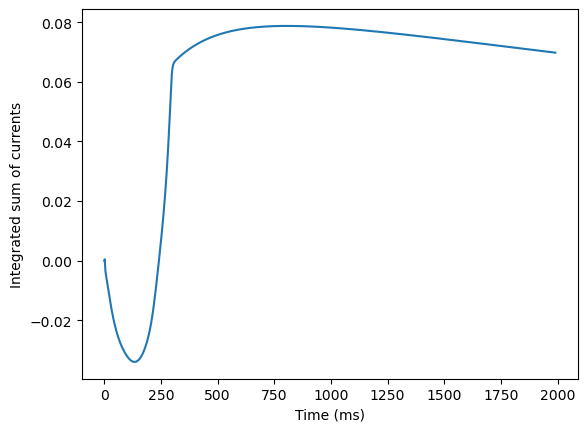

In [13]:
plt.figure()
x = np.linspace(0, 1990, 199000)
plt.plot(x, IKr, label = 'IKr')
plt.plot(x, ICaL, label = 'ICaL')
plt.plot(x, INaL, label = 'INaL')
plt.plot(x, IKs, label = 'IKs')
plt.plot(x, IK1, label = 'IK1')
plt.plot(x, Ito, label = 'Ito')
plt.ylim([-2, 2])
plt.xlabel('Time (ms)')
plt.ylabel('Ionic current')
plt.legend()

# Plot the integration
plt.figure()
plt.ylabel('Integrated sum of currents')
plt.xlabel('Time (ms)')
plt.plot(x, np.cumsum(IKr + ICaL + IKs + INaL + IK1 + Ito)*1e-05) # Integrate